In [11]:
import numpy as np
import scipy as sp
from scipy import io,integrate,sparse
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle,Circle

from quantum import *
#from lanczos_bin import mystep,distribution

from IPython.display import clear_output
np.set_printoptions(linewidth=300)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
plt.rcParams['text.latex.preamble'] = r'\usepackage{times}\renewcommand{\vec}{\mathbf}'
plt.rc('text', usetex=True)
plt.rc('font', family='serif') #plt.rc('font', **{'serif': ['Times']})

## Set up system

In [13]:
s = 1/2
M = int(2*s+1)

x,y = 10,2

N = x*y
n = M**N

In [14]:
J = 1
h = 1*J

Jz_T_base = h*np.ones(N)
J_T_base = np.zeros((N,N))
for i in range(N):
    for j in range(N):
        if i//x==j//x and np.abs(i-j)==1: # horizontal neighbor
            J_T_base[i,j] = 1
        if i%x==j%x and np.abs(i-j)==x:# vertical neighbor
            J_T_base[i,j] = -.45

In [15]:
problems = [
    {
        'S_idx':[i,i+x]
    }
    for i in range(5)
]

In [16]:
EVs = []
E0s = []
E0Bs = []
ρEVs_lt = []

for p_idx,problem in enumerate(problems):
    
    βs = 1/np.logspace(-2.2,2.5,80)
    n_ave = 50
    k = 30
    
    clear_output(wait=True)
    print(f'problem {p_idx}: {n_ave}, {k}')

    S_idx = problem['S_idx']
    B_idx = np.setdiff1d(np.arange(N),S_idx)

    N_S = len(S_idx)
    N_B = N - N_S
    
    permute = np.hstack([S_idx,B_idx])
    permute_inv = np.argsort(permute)
    J_T = J_T_base[np.ix_(permute,permute)]
    Jz_T = Jz_T_base[permute]

    J_B,J_S,J_I,Jz_B,Jz_S,Jz_I = get_connection_matrix(J_T,Jz_T,N_S)
    H_T,H_S,H_B,H_I,H_S_iso,H_B_iso = get_hamiltonians(J_T,Jz_T,N_S,s,method='explicit')


    # get base energy. This is used to avoid numerical overflow at low temperature
    E0,ψ0 = sp.sparse.linalg.eigsh(H_T,1,which='SA')
    ρ0 = np.zeros((M**N_S,M**N_S),dtype='complex')
    for m in range(M**N_S):
        for n in range(M**N_S):
            ρ0[m,n] = (ψ0[m*M**N_B:(m+1)*M**N_B].conj().T@ψ0[n*M**N_B:(n+1)*M**N_B])[0,0]

    E0s.append(E0)
    ρEVs_lt.append(np.linalg.eigvalsh(ρ0))
    
    E0B,_ = sp.sparse.linalg.eigsh(H_B_iso,1,which='SA')
    E0Bs.append(E0B)

    trB_expH_T,tr_expH_B,trB_H_I = get_partial_traces(H_T,H_T,H_B_iso,βs,k,n_ave,M,N,N_S,N_B,E0*1.1,s_print=5)

    EV = np.zeros((len(βs),M**N_S))
    for l,β in enumerate(βs):
        try:
            EV[l] = np.linalg.eigvalsh(trB_expH_T[l]/tr_expH_B[l])
        except:
            pass
        
    EVs.append(EV)

problem 4: 50, 30


In [18]:
np.save('ladder_EVs',EVs)
EVs=np.load('ladder_EVs.npy')

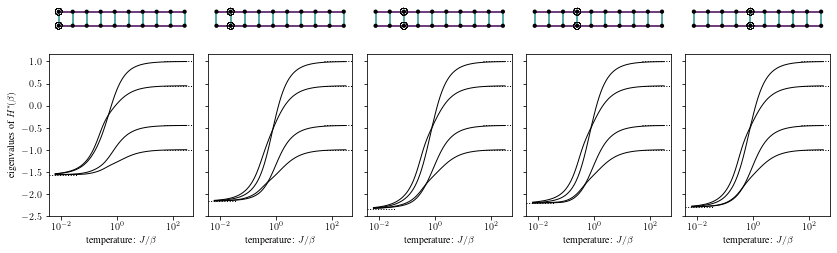

In [19]:
fig,axs = plt.subplots(2,5,figsize=(14,4),sharey='row',sharex=False,gridspec_kw={'height_ratios': [1,4]})

fig.subplots_adjust(wspace=.1,hspace=.15)

#axs = np.reshape(axs,-1)

isolated_EVs = np.linalg.eigvalsh(H_S_iso.A)

for i,problem in enumerate(problems):
    axs[0,i].set_aspect('equal')

    S_idx = problem['S_idx']
    B_idx = np.setdiff1d(np.arange(N),S_idx)

    for ii in range(N):
        axs[0,i].add_patch(Circle((ii%x,ii//x),.15, facecolor='k',edgecolor=None,zorder=10))
        for jj in range(ii):
            if J_T_base[ii,jj] == 1:
                axs[0,i].plot([ii%x,jj%x],[ii//x,jj//x],lw=1.5,color=plt.cm.viridis(.0))
            if J_T_base[ii,jj] == -.45:
                axs[0,i].plot([ii%x,jj%x],[ii//x,jj//x],lw=1.5,color=plt.cm.viridis(.5))

            for S in S_idx:
                axs[0,i].add_patch(Circle((S%x,S//x), .25, facecolor='None',lw=.25,edgecolor='k',zorder=10))

    axs[0,i].set_axis_off()
    
for i,problem in enumerate(problems):
    
    S_idx = problem['S_idx']
    B_idx = np.setdiff1d(np.arange(N),S_idx)

    permute = np.hstack([S_idx,B_idx])
    permute_inv = np.argsort(permute)
    J_T = np.copy(J_T_base)[np.ix_(permute,permute)]
    Jz_T = np.copy(Jz_T_base)[permute]
    
    if False:
        for E in ρEVs_lt[i]:
            axs[1,i].axhline(E,0,.1,lw=1,ls=':',color='k',label='bare system')
            axs[1,i].axhline(1/M**N_S,.8,1,lw=1,ls=':',color='k',label='bare system')

        isolated_EVs = np.linalg.eigvalsh(H_S_iso.A)

    #    ρEVs_iso = np.exp(-βs[:,None]*isolated_EVs)/np.sum(np.exp(-βs[:,None]*isolated_EVs),axis=1)[:,None]
    #    axs[1,i].plot(1/βs,ρEVs_iso,lw=1,ls=':',color='k',label='bare system')

        ρEVs = np.copy(EVs[i])
        ρEVs /= np.sum(ρEVs,axis=1)[:,None]
        axs[1,i].plot(1/βs,ρEVs,lw=1,color='k',label='system in bath')
    #    axs[2,i].plot(1/βs,-np.sum(ρEVs*np.log(ρEVs),axis=1),lw=1,color='r',label='system in bath')
        axs[1,i].set_xscale('log')
        axs[1,i].set_xticks([1e-2,1e0,1e2])
        axs[1,i].set_xticklabels([])

    for E in isolated_EVs:
        axs[1,i].axhline(E,.8,1,lw=1,ls=':',color='k',label='isolated system')
    axs[1,i].axhline(E0s[i]-E0Bs[i],0,.2,lw=1,ls=':',color='k',label='isolated system')

    H_mf_EVs = -1/βs[:,None]*np.log(EVs[i])
    axs[1,i].plot(1/βs,H_mf_EVs,lw=1,color='k',label='system in bath')
    
    
    axs[1,i].set_xscale('log')
    axs[1,i].set_xticks([1e-2,1e0,1e2])
    axs[1,i].set_xlabel('temperature: $J/\\beta$')

#axs[1,0].set_ylabel('probability')
axs[1,0].set_ylabel('eigenvalues of $H^*\!(\\beta)$')
#axs[3].set_xlabel('temperature')

#handles, labels = axs[1,0].get_legend_handles_labels()
#unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
#axs[1,0].legend(*zip(*unique))

#plt.suptitle('mean force Hamiltonian eigenvalues')

plt.savefig('spin_imgs/ladder_Hmf_eigs.pdf',bbox_inches='tight')